In [462]:
import numpy as np
import random
from benchmark_functions import *
import statistics
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
# Selection -> Página 103
# Evolutionary Strategy -> Página 115

In [463]:
def normalize(x,min,max):
    return min + x*(max - min)

In [464]:
class Individual():
    def __init__(self, dimension_genes, parameter_genes, fitness_function, min_range:int = -1, max_range:int = 1, tau_factor:float = 1, tau_l_factor:float = 1, sigma_max:float=4):
        self.min = min_range
        self.max = max_range
        if len(dimension_genes) != len(parameter_genes):
            raise Exception("Tamanho do vetor de dimensões e de sigma devem ser iguais")
        self.dimension_genes = np.array(dimension_genes, dtype = np.float64)
        self.parameter_genes = np.array(parameter_genes, dtype = np.float64)
        self.fitness_function = fitness_function
        self.fitness = self.calculate_fitness()
        
        
        self.tau_l = tau_l_factor*(1 / np.sqrt(2*len(dimension_genes)))
        self.tau = tau_factor*(1 / np.sqrt(2*np.sqrt(len(dimension_genes))))
        self.sigma_max = (max_range-min_range) * sigma_max
        self.epsilon = (max_range-min_range) * 10**-12
        
    def __str__(self):
        return str(self.dimension_genes)
    
    def __repr__(self):
        return self.__str__()
    
        
    def calculate_fitness(self):
        return -self.fitness_function(self.dimension_genes)
    
    def is_valid_solution(self):
        return True if self.fitness == 0 else False
    
    def mutate(self):
        global_normal = np.random.normal(0,1)
        for i in range(len(self.dimension_genes)):
            lognormal = np.exp(self.tau_l * global_normal + self.tau * np.random.normal(0,1))
            sigma_l = self.parameter_genes[i] * lognormal
            sigma_l = min(max(sigma_l, self.epsilon), self.sigma_max)
            self.parameter_genes[i] = sigma_l  
            
        for i in range(len(self.dimension_genes)):
            x_l = self.dimension_genes[i]
            count = 0
            
            # Tenta até 10 vezes gerar um valor dentro dos limites
            while count < 10:
                new_x = x_l + self.parameter_genes[i] * np.random.normal(0,1)
                if self.min <= new_x <= self.max:
                    x_l = new_x
                    break
                count += 1
            else: 
                new_x = x_l + self.parameter_genes[i] * np.random.normal(0,1)
                if new_x > self.max:
                    x_l = 2 * self.max - new_x
                elif new_x < self.min:
                    x_l = 2 * self.min - new_x
                else:
                    x_l = new_x
            
            self.dimension_genes[i] = x_l
        
        self.fitness = self.calculate_fitness()
            
    
class Population():
    def __init__(self, dimensions, size_population, qtt_childs, fitness_function, min_range:int = -1, max_range:int = 1, tau_factor:float = 1, tau_l_factor:float = 1, sigma_max:float = 4, sigma_factor:float = 0.01):
        self.individuals = []
        self.qtt_childs = qtt_childs
        self.fitness_function = fitness_function
        self.min_range = min_range
        self.max_range = max_range
        self.dimensions = dimensions
        self.tau_factor = tau_factor
        self.tau_l_factor = tau_l_factor
        self.sigma_factor = sigma_factor
        self.sigma_max = sigma_max
        
        self.all_mean = []
        self.all_stdev = []
        self.all_best_ind = []
        self.sigmas_mean = []
        
        for _ in range(size_population):
            dimension_genes = np.random.rand(dimensions)
            parameter_genes = np.ones(dimensions)*(self.max_range-self.min_range)*sigma_factor
            
            dimension_genes = normalize(dimension_genes, self.min_range, self.max_range)
            self.individuals.append(Individual(dimension_genes,parameter_genes, fitness_function, min_range, max_range, tau_factor, tau_l_factor, sigma_max))
        
        print("------HiperParâmetros-------")
        print(f"size_population: {size_population}")
        print(f"qtt_childs: {self.qtt_childs}")
        print(f"tau_factor: {self.tau_factor}")
        print(f"tau_l_factor: {self.tau_l_factor}")
        print(f"sigma_factor: {self.sigma_factor}")
        print(f"sigma_max: {self.sigma_max}")
    
    def global_recombination(self):
        dimension_genes = []
        parameter_genes = []
        for i in range(self.dimensions):
            pai1 = random.choice(self.individuals)
            pai2 = random.choice(self.individuals) 
            if random.random()>0.5:
                dimension_genes.append(pai1.dimension_genes[i])
            else:
                dimension_genes.append(pai2.dimension_genes[i])
                
            parameter_genes.append((pai1.parameter_genes[i] + pai2.parameter_genes[i])/2)
            
        return Individual(dimension_genes, parameter_genes, self.fitness_function, self.min_range, self.max_range, self.tau_factor, self.tau_l_factor, self.sigma_max)
    
    def select_individuals(self, offspring):
        return sorted(offspring, key=lambda x: x.fitness, reverse=True)
    
    def melhor_individuo(self):
        return max(self.individuals, key=lambda x: x.fitness)
    
    def fitness_media(self):
        return np.mean([individual.fitness for individual in self.individuals])
    
    def fitness_stdev(self):
        return statistics.stdev([individual.fitness for individual in self.individuals])
    
    def optimize(self, generations:int):
        print(f"generations: {generations}")
        generation = 0
        with tqdm(range(generations), desc=f"Optimizing {self.fitness_function.__name__} function") as bar:
            for g in bar:
                childs = []
                for _ in range(self.qtt_childs):
                    child = self.global_recombination()
                    child.mutate()
                    childs.append(child)

                #childs.extend(self.individuals)
                childs = self.select_individuals(childs)[:len(self.individuals)]
                self.individuals = childs
                
                self.all_mean.append(self.fitness_media())
                self.all_stdev.append(self.fitness_stdev())
                self.all_best_ind.append(self.melhor_individuo().fitness)
                self.sigmas_mean.append(np.max([np.max(ind.parameter_genes) for ind in self.individuals]))

                bar.set_postfix({
                    "best_ind": f"{self.melhor_individuo().fitness:.6f}",
                    "mean_sigma": f"{self.sigmas_mean[-1]:.6f}"
                })
                
                generation+=1
            
        return self.melhor_individuo(), generation
            

In [465]:
populations = []
list_attempts= []
max_attempts = 250
for i in range(1):
    pop = Population(30, 100, 100*5, rastrigin, RASTRIGIN_MIN_LIMIT, RASTRIGIN_MAX_LIMIT, tau_factor = 0.01, tau_l_factor = 0.09, sigma_max=3,sigma_factor = 0.0001)
    goat, tentativa = pop.optimize(max_attempts)
    list_attempts.append(tentativa)
    print(f"x: {goat} | f(x): {-goat.calculate_fitness()} | Tentativa: {tentativa} | Execução: {i+1}")
    populations.append(pop)

------HiperParâmetros-------
size_population: 100
qtt_childs: 500
tau_factor: 0.01
tau_l_factor: 0.09
sigma_factor: 0.0001
sigma_max: 3
generations: 250


Optimizing rastrigin function: 100%|██████████| 250/250 [00:32<00:00,  7.81it/s, best_ind=-11.946845, mean_sigma=0.001065]

x: [-9.95287922e-01 -9.97033449e-01 -9.96405000e-01  4.43421617e-04
 -1.05375627e-03  3.80398430e-04 -1.14368621e-03 -1.21970816e-03
  1.57790080e-03  8.54780601e-04  9.96751289e-01  4.44096439e-04
 -9.93801578e-01 -9.95137219e-01  9.94114894e-01  3.64802524e-04
 -1.33998482e-03  6.97158741e-04  9.97196223e-01  1.48581741e-03
  9.94293591e-01  9.96327574e-01 -9.96884097e-01  9.95151451e-01
  7.51923049e-04 -9.29875051e-04 -8.51343639e-05 -3.20453831e-04
  5.38473186e-04  5.62184801e-06] | f(x): 11.946844645003068 | Tentativa: 250 | Execução: 1


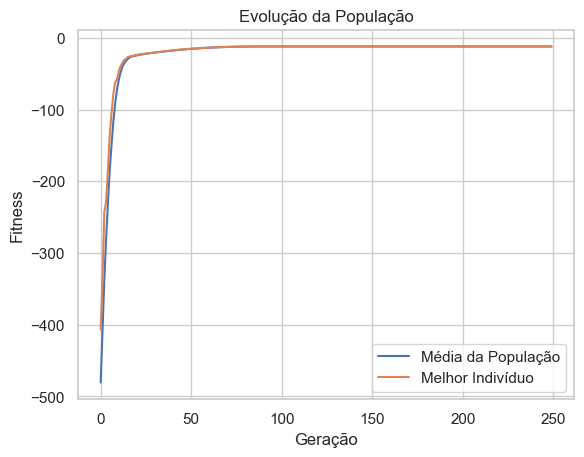

In [466]:
plt.plot(populations[0].all_mean, label='Média da População')
plt.plot(populations[0].all_best_ind, label='Melhor Indivíduo')
plt.legend()
plt.xlabel("Geração")
plt.ylabel("Fitness")
plt.title("Evolução da População")
plt.grid(True)
plt.show()

In [467]:
FUNCTION_CONFIGS = {
    ackley : {
        'runs' : 30,
        'generations' : 250,
        'population' : 100,
        'lambda' : 500,
        'tau_factor' : 0.1,
        'tau_l_factor' : 0.2,
        'sigma_max' : 2,
        'sigma_factor' : 0.001
    },
    rastrigin : {
        'runs' : 30,
        'generations' : 250,
        'population' : 100,
        'lambda' : 500,
        'tau_factor' : 0.1,
        'tau_l_factor' : 0.2,
        'sigma_max' : 3,
        'sigma_factor' : 0.001
    },
    schwefel : {
        'runs' : 30,
        'generations' : 250,
        'population' : 100,
        'lambda' : 500,
        'tau_factor' : 0.005,
        'tau_l_factor' : 0.01,
        'sigma_max' : 3,
        'sigma_factor' : 0.001
    },
    rosenbrock : {
        'runs' : 30,
        'generations' : 700,
        'population' : 100,
        'lambda' : 500,
        'tau_factor' : 0.1,
        'tau_l_factor' : 0.01,
        'sigma_max' : 3,
        'sigma_factor' : 0.0001
    },
    
}

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
sns.set_theme(style="whitegrid")
axes = axes.flatten()

for i, (func, cfg) in enumerate([(rosenbrock, FUNCTION_CONFIGS[rosenbrock])]):
    print(f"=== Otimizando função {cfg['name']} ===")

    global_best_val = float('inf')
    global_best = None
    run_history = []
    runs = []

    for _ in range(cfg['runs']):
        pop = Population(30, 100, 100*5, rastrigin, RASTRIGIN_MIN_LIMIT, RASTRIGIN_MAX_LIMIT, tau_factor = cfg['tau_factor'], tau_l_factor = cfg['tau_l_factor'], sigma_max=cfg['sigma_max'],sigma_factor = cfg['sigma_factor'])
        best_ind, val, history = pop.optimize(cfg['generations'])
        runs.append(val)
        run_history.append(history)

        if val < global_best_val:
            global_best = best_ind
            global_best_val = val

    average = np.mean(runs)
    deviation = np.std(runs)
    gens = np.arange(cfg['generations'])

    run_history = np.array(run_history)
    mean_curve = np.mean(run_history, axis=0)
    std_curve = np.std(run_history, axis=0)

    ax = axes[i]
    ax.plot(gens, mean_curve, label="Média", color="blue")
    ax.fill_between(gens, mean_curve - std_curve, mean_curve + std_curve,
                    color="blue", alpha=0.3, label="Desvio Padrão")
    ax.set_title(f"Convergência - {cfg['name']}")
    ax.set_xlabel("Geração")
    ax.set_ylabel("Valor")
    ax.legend(loc="upper right", fontsize=9)

    stats_text = (
        "Valor Final\n"
        f"µ: {average:.6f}\n"
        f"σ: {deviation:.6f}\n"
        f"Mínimo: {global_best_val:.6f}"
    )
    ax.text(0.98, 0.85, stats_text,
            transform=ax.transAxes,
            fontsize=9,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

plt.tight_layout()
plt.show()


SyntaxError: invalid syntax (4066755249.py, line 15)